In [1]:
import scipy as sp
import scipy.io
from scipy import stats
import os
import numpy as np
import pandas as pd
import glob
import csv
from collections import Iterable
import matplotlib.pylab as plt
import matplotlib.patches as patch
from datetime import datetime, timedelta
import matplotlib.dates as mdates

In [2]:
from IPython.display import clear_output, Image, display

In [4]:
projects_df = pd.read_csv('C:/Users/samaher/Desktop/Data/projects.csv',engine='python')
donations_df = pd.read_csv('C:/Users/samaher/Desktop/Data/Donations.csv',engine='python')


In [5]:
finished_projects_df = projects_df[projects_df['Project Current Status'].str.contains('Fully Funded|Expired')].copy()

rel_date_cols = ['Project Posted Date', 'Project Fully Funded Date', 'Project Expiration Date']
finished_projects_df[rel_date_cols] = finished_projects_df[rel_date_cols].apply(pd.to_datetime)

nulls = finished_projects_df['Project Expiration Date'].isnull()
finished_projects_df.loc[nulls, 'Project Expiration Date'] = (finished_projects_df.loc[nulls, 'Project Posted Date'] +
                                                              pd.DateOffset(months = 4))

expired = finished_projects_df['Project Fully Funded Date'].isnull()
finished_projects_df.loc[expired, 'Project Fully Funded Date'] = finished_projects_df.loc[expired, 'Project Expiration Date']
finished_projects_df = finished_projects_df.rename(columns = {'Project Fully Funded Date':'Project End'})

nulls = finished_projects_df['Project End'].isnull()
finished_projects_df.loc[nulls, 'Project End'] = finished_projects_df.loc[nulls, 'Project Posted Date'] + pd.DateOffset(months = 4)
finished_projects_df['Days Open'] = ((finished_projects_df['Project End'] - finished_projects_df['Project Posted Date'])/
                                     np.timedelta64(1, 'D')).astype(int)

finished_projects_df = finished_projects_df[finished_projects_df['Days Open']>0]
finished_projects_df= finished_projects_df.reset_index(drop = True)

In [6]:
finished_projects_df['Project End'] = pd.to_datetime(finished_projects_df['Project End'])
all_fin_proj_posted_grouped = finished_projects_df.groupby(pd.Grouper(key = 'Project Posted Date', freq = 'W'))

ff_proj_completed_df = finished_projects_df[finished_projects_df['Project Current Status'] == 'Fully Funded']
ff_proj_completed_grouped = ff_proj_completed_df.groupby(pd.Grouper(key = 'Project End', freq = 'W'))

ff_proj_posted_df = finished_projects_df[finished_projects_df['Project Current Status'] == 'Fully Funded']
ff_proj_posted_grouped = ff_proj_posted_df.groupby(pd.Grouper(key = 'Project Posted Date', freq = 'W'))

exp_proj_df = finished_projects_df[finished_projects_df['Project Current Status'] == 'Expired']
exp_proj_posted_grouped = exp_proj_df.groupby(pd.Grouper(key = 'Project Posted Date', freq = 'W'))

In [7]:
weeks = pd.Series(ff_proj_completed_grouped.groups).reset_index()
school_start_inds = weeks['index'].apply(lambda x: x.week == 35)
school_end_inds = weeks['index'].apply(lambda x: x.week == 22)

school_start_inds.iloc[0] = True
school_end_inds.iloc[-1] = True

school_year = list(zip(weeks.loc[school_start_inds, 'index'], weeks.loc[school_end_inds, 'index']))
school_year

[(Timestamp('2013-01-06 00:00:00'), Timestamp('2013-06-02 00:00:00')),
 (Timestamp('2013-09-01 00:00:00'), Timestamp('2014-06-01 00:00:00')),
 (Timestamp('2014-08-31 00:00:00'), Timestamp('2015-05-31 00:00:00')),
 (Timestamp('2015-08-30 00:00:00'), Timestamp('2016-06-05 00:00:00')),
 (Timestamp('2016-09-04 00:00:00'), Timestamp('2017-06-04 00:00:00')),
 (Timestamp('2017-09-03 00:00:00'), Timestamp('2018-05-13 00:00:00'))]

In [9]:
ranges = finished_projects_df[['Project Posted Date','Project End']].applymap(lambda x: int(x.timestamp()))
ranges = ranges.apply(lambda x: range(x[0], x[1], 86400), axis = 1) 
ranges = np.concatenate(ranges.apply(list).values)

active_hist, xvals = np.histogram(ranges, bins = np.arange(ranges.min(), ranges.max()+1, 86400))
to_time_vec = np.vectorize(datetime.utcfromtimestamp)
xvals = to_time_vec(xvals[:-1])

active_proj = pd.DataFrame({'date':xvals, 'Active Projects':active_hist})

In [10]:
daily_fund_rate = ff_proj_completed_df.groupby(pd.Grouper(key = 'Project End', freq = 'D')).size()
daily_fund_rate = daily_fund_rate.reset_index()
daily_fund_rate['Project End'] = pd.to_datetime(daily_fund_rate['Project End'])
daily_fund_rate = daily_fund_rate.rename(columns={0: 'Number funded'})



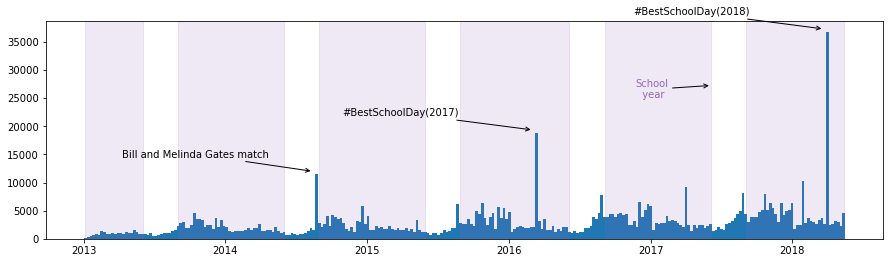

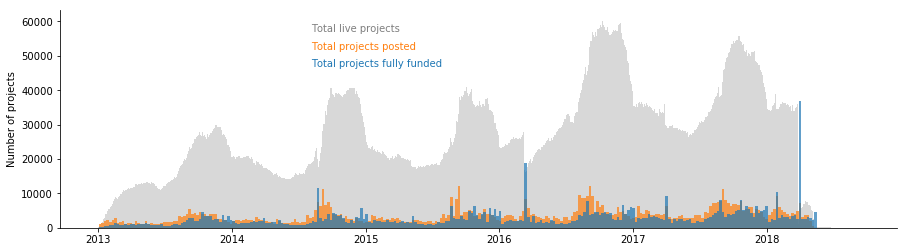

In [11]:
weekly_posted_all = all_fin_proj_posted_grouped.size()

fig,ax = plt.subplots(1,1, figsize = (15,4), sharex = True)
ax.bar(xvals, active_hist, 1, alpha = 0.3, color = 'C7')
ax.bar(weekly_posted_all.index, weekly_posted_all, 7, color = 'C1', alpha = 0.7)
ax.bar(weekly_funded.index, weekly_funded, 7, color = 'C0', alpha = 0.7)

ax.text(0.3, 0.9, 'Total live projects', color = 'C7', transform=ax.transAxes)
ax.text(0.3, 0.82, 'Total projects posted', color = 'C1', transform=ax.transAxes)
ax.text(0.3, 0.74, 'Total projects fully funded', color = 'C0', transform=ax.transAxes)
xrange = ax.get_xlim()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(xrange)
ax.set_ylabel('Number of projects')

fig.savefig('Stacked_proj_timeline.png', format = 'PNG')
plt.show()

r2:0.22210857511
p: 7.83453502429e-17


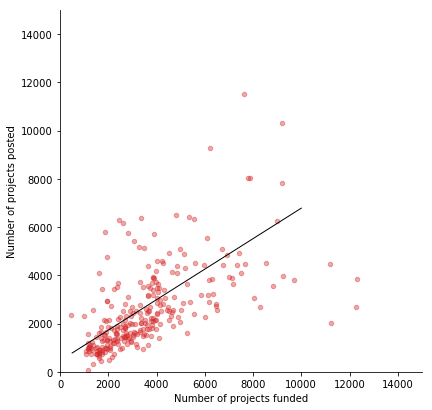

In [13]:
from numpy.polynomial.polynomial import polyfit

fig,ax = plt.subplots(1,1, figsize = (6,6))

ax.scatter(weekly_posted_all, weekly_funded.iloc[:-1], alpha = 0.4, s = 20,color = 'C3')

m, b, r_value, p_value, std_err = scipy.stats.linregress(weekly_posted_all, weekly_funded.iloc[:-1])
ax.plot(np.array([500,10000]), np.array([500,10000]) * m + b, 'k', linewidth = 1)
text

ax.set_ylabel('Number of projects posted')
ax.set_xlabel('Number of projects funded')
plt.xlim(0, 15000)
plt.ylim(0, 15000)
plt.gca().set_aspect('equal', adjustable='box')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('correlation_posted_funded.png', format = 'png')

print('r2:' + str(r_value**2))
print('p: ' + str(p_value))
plt.show()